Training a neural network to predict $\delta C_9$

Setup

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import torch
from torch import nn

from library.nn_training import select_device, train_and_eval
from library.datasets import Signal_Unbinned_Dataset, Bootstrapped_Signal_Unbinned_Dataset
from library.plotting import plot_loss_curves, plot_prediction_linearity

device = select_device()

Device:  cuda


Load / Generate Datasets

In [23]:
regenerate = True

level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"
raw_trials = {"train": range(0,20), "eval": range(20,30)}
q_squared_veto = False
std_scale = True

# set datasets #
num_events_per_set = 128_000
num_sets_per_label = {"train": 10, "eval": 10}

set_datasets = {
    "train": Bootstrapped_Signal_Unbinned_Dataset(level=level, split="train", save_dir=save_dir,), 
    "eval": Bootstrapped_Signal_Unbinned_Dataset(level=level, split="eval", save_dir=save_dir,)
}

if regenerate:
    set_datasets["train"].generate(raw_trials["train"], raw_signal_dir, num_events_per_set, num_sets_per_label["train"], q_squared_veto=q_squared_veto, std_scale=std_scale)
    set_datasets["eval"].generate(raw_trials["eval"], raw_signal_dir, num_events_per_set, num_sets_per_label["eval"], q_squared_veto=q_squared_veto, std_scale=std_scale)

set_datasets["train"].load()
set_datasets["eval"].load()

# event datasets #
# event_datasets = {
#     "train": Signal_Unbinned_Dataset(level=level, split="train", save_dir=save_dir),
#     "eval": Signal_Unbinned_Dataset(level=level, split="eval", save_dir=save_dir)
# }

# if regenerate:
#     event_datasets["train"].generate(raw_trials["train"], raw_signal_dir, q_squared_veto=q_squared_veto, std_scale=std_scale)
#     event_datasets["eval"].generate(raw_trials["eval"], raw_signal_dir, q_squared_veto=q_squared_veto, std_scale=std_scale)

# event_datasets["train"].load(device)
# event_datasets["eval"].load(device)

In [ ]:
set_datasets["train"].features = set_datasets["train"].features.mean(dim=1)
set_datasets["eval"].features = set_datasets["eval"].features.mean(dim=1)

mu = set_datasets["train"].features.mean()
sigma = set_datasets["train"].features.std()

set_datasets["train"].features = (set_datasets["train"].features - mu) / sigma
set_datasets["eval"].features = (set_datasets["eval"].features - mu) / sigma

In [24]:
mu = set_datasets["train"].labels.mean()
sigma = set_datasets["train"].labels.std()

set_datasets["train"].labels = (set_datasets["train"].labels - mu) / sigma
set_datasets["eval"].labels = (set_datasets["eval"].labels - mu) / sigma

set_datasets["train"].labels = set_datasets["train"].labels.reshape(set_datasets["train"].labels.shape, 1)

Train / Load Model


epoch 0 complete:
    Train loss: 0.9979271292686462
    Eval loss: 1.0004981756210327

peak gpu memory usage: 7.56998 GB

epoch 1 complete:
    Train loss: 1.0192359685897827
    Eval loss: 1.0018303394317627

peak gpu memory usage: 7.56998 GB

epoch 2 complete:
    Train loss: 0.9913465976715088
    Eval loss: 1.0105762481689453

peak gpu memory usage: 7.56998 GB

epoch 3 complete:
    Train loss: 0.9737685918807983
    Eval loss: 0.9845424294471741

peak gpu memory usage: 7.56998 GB

epoch 4 complete:
    Train loss: 0.9902318716049194
    Eval loss: 0.9855647683143616

peak gpu memory usage: 7.56998 GB

epoch 5 complete:
    Train loss: 0.9786397814750671
    Eval loss: 0.9658526182174683

peak gpu memory usage: 7.56998 GB

epoch 6 complete:
    Train loss: 0.9675293564796448
    Eval loss: 0.9653712511062622

peak gpu memory usage: 7.56998 GB

epoch 7 complete:
    Train loss: 0.9429484009742737
    Eval loss: 0.9393619298934937

peak gpu memory usage: 7.56998 GB

epoch 8 complet

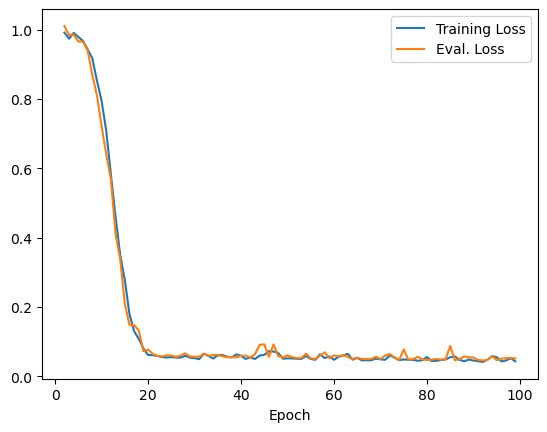

In [35]:
class Set_Trained_Regressor_NN(nn.Module):
    """
    Neural network trained on sets (that works event-by-event?).
    """
    def __init__(self, save_dir, nickname):
        super().__init__()

        self.nickname = nickname
        self.save_path = Path(save_dir).joinpath(f"{nickname}.pt")

        self.f = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        
        # self.g = nn.Sequential(
        #     nn.Linear(16, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 1)
        # )
        
    def forward(self, x):
        fs = self.f(x)
        avgs = fs.mean(dim=1)
        # gs = self.g(avgs)
        return avgs

retrain = True
save_dir = "../../state/new_physics/models"
nickname = "test1"
model = Set_Trained_Regressor_NN(save_dir, nickname)

if retrain:
    
    learning_rate = 8e-3
    epochs = 100
    train_batch_size = 32
    eval_batch_size = 32
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_table = train_and_eval(
        model, 
        set_datasets["train"], set_datasets["eval"], 
        loss_fn, 
        optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=True)
    
    torch.save(model.state_dict(), model.save_path)

    _, ax = plt.subplots()
    skip_first = 2
    plot_loss_curves(loss_table["epoch"][skip_first:], loss_table["train_loss"][skip_first:], loss_table["eval_loss"][skip_first:], ax)
    plt.show()

else:
    model.load_state_dict(torch.load(model.save_path, weights_only=True))
    model.to(device)

Evaluate Model

In [36]:
split = "train"

feat = set_datasets[split].features.to(device)
labels = set_datasets[split].labels.to(device)

model.eval()
with torch.no_grad():
    yhat = model(feat)

unique_labels = labels.unique()
separated_yhats = [yhat[torch.where(labels==label)] for label in unique_labels]
avgs = [i.mean() for i in separated_yhats]
stds = [i.std() for i in separated_yhats]

unique_labels = [i.cpu().numpy() for i in unique_labels]
avgs = [i.cpu().numpy() for i in avgs]
stds = [i.cpu().numpy() for i in stds]

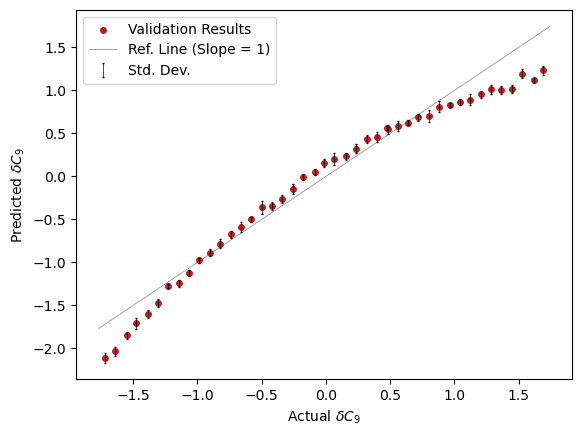

In [37]:
_, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    unique_labels, avgs, stds,
    ref_line_buffer=0.05,
    # xlim=(-2.25, 1.35),
    # ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)


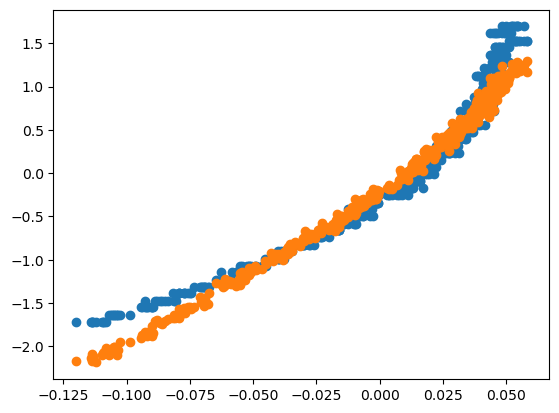

In [38]:
plt.scatter(feat[:,:,1].mean(dim=1).cpu(), labels.cpu())
plt.scatter(feat[:,:,1].mean(dim=1).cpu(), yhat.cpu())

In [ ]:
from library.datasets import Test_Linear_Dataset

test_linear_dataset = Test_Linear_Dataset()

class Test_Regressor_NN(nn.Module):
    """
    Neural network trained on sets (that works event-by-event?).
    """
    def __init__(self, save_dir, nickname):
        super().__init__()

        self.nickname = nickname
        self.save_path = Path(save_dir).joinpath(f"{nickname}.pt")

        self.lin = nn.Sequential(
            nn.Linear(1, 1),
        )
        
    def forward(self, x):
        z = self.lin(x)
        return z

retrain = True
save_dir = "../../state/new_physics/models"
nickname = "test_testlin_1"
model = Test_Regressor_NN(save_dir, nickname)

if retrain:
    
    learning_rate = 3e-2
    epochs = 75
    train_batch_size = 16
    eval_batch_size = 16
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_table = train_and_eval(
        model, 
        test_linear_dataset, test_linear_dataset, 
        loss_fn, 
        optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=True)
    
    torch.save(model.state_dict(), model.save_path)

    _, ax = plt.subplots()
    skip_first = 2
    plot_loss_curves(loss_table["epoch"][skip_first:], loss_table["train_loss"][skip_first:], loss_table["eval_loss"][skip_first:], ax)
    plt.show()

else:
    model.load_state_dict(torch.load(model.save_path, weights_only=True))
    model.to(device)


model.eval()
with torch.no_grad():
    yhat = model(test_linear_dataset.features.to(device))

avgs = yhat.mean(dim=1)
stds = yhat.std(dim=1)

_, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    test_linear_dataset.labels.squeeze().cpu().numpy(), avgs.cpu().numpy(), stds.cpu().numpy(),
    ref_line_buffer=0.05,
    # xlim=(-2.25, 1.35),
    # ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)